
Getting Started
============

Click [here](https://github.com/kxytechnologies/kxy-python/blob/master/docs/latest/introduction/getting_started/index.ipynb) to download this page as a Jupyter Notebook.

The **KXY platform** is the _only AutoML platform_ dedicated to bringing about **business value** by addressing two classes of questions that are fundamental to the data science life cycle in a rigorous, fast, and cost-effective manner:

* **Pre-Learning Questions**: How valuable is a dataset for improving decision making, in an absolute sense and relative to others?
* **Post-Learning Questions**: How do you explain what your trained model is doing, including ensuring it is not biased? Which action would yield a higher ROI, trying to improve your trained model using the same datasets, or investing in acquiring additional and complementary datasets?


Installation
-------------

The KXY python package can be installed from PyPi by running

``pip install kxy``

The package only supports python 3.


Authentication
-----------------

All heavy-duty operations, including but not limited to solving any **maximum-entropy optimization problem**, are run on the KXY infrastructure and require an API key. The API key should be set in the environment variable ``KXY_API_KEY``. 

This can be done in MacOS or Linux terminals by running 

``export KXY_API_KEY='YOUR API KEY GOES HERE'``

or from within your python program by running 

In [1]:
import os
# os.environ['KXY_API_KEY'] = 'YOUR API KEY GOES HERE'

Toy Examples
----------------

### Classification

#### Loading Data

In [2]:
import pandas as pd
# It is crucial to import the kxy package to access our methods
# from all pandas DataFrame instances.
import kxy 
# Bank note UCI dataset (binary classification)
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00267/'\
	'data_banknote_authentication.txt'
df = pd.read_csv(url, names=['Variance', 'Skewness', 'Kurtosis', 'Entropy', 'Is Fake'])

#### Problem Feasibility

To what extent can we predict whether the bank note is fake from an image using provided 
inputs (irrespective of the classification model)?

In [3]:
'Classification Feasibility: %.4f nats' % df.kxy.classification_feasibility('Is Fake')

'Classification Feasibility: 2.3410 nats'

The higher the feasibility score is relative to the entropy of the response, the better. A value of 0
means no model can successfully solve this classification problem using provided inputs, no
matter how complex, no matter how deep. In such as a case, resources should be allocated to 
looking for more relevant datasets to use as inputs, rather than increasing model complexity.

In [4]:
'Label Shannon Entropy: %.4f nats' % kxy.discrete_entropy(df['Is Fake'].values)

'Label Shannon Entropy: 0.6870 nats'

#### Input Importance

Once we know the problem is feasible using inputs at hand, the next question before we jump
into modeling is what are the inputs that are the most useful for solving this problem. Once
more, this question is asked and answered independently from any classification model (this is a **pre-learning** problem), and reduces time wasted improving models fitted on irrelevant inputs.

First, we determine how useful each input is, in isolation, for solving this classification problem.

In [5]:
importance_df_1 = df.kxy.individual_input_importance('Is Fake')
importance_df_1.rename(columns={\
        'input': 'Input', 'individual_importance': 'Individual Importance',\
        'normalized_individual_importance': 'Normalized Individual Importance',\
        'cum_normalized_individual_importance': \
                'Cum Normalized Individual Importance'}).round(2)\
        .set_index(['Input'])

,Individual Importance,Normalized Individual Importance,Cum Normalized Individual Importance
Input,,,
Variance,1.31,0.72,0.72
Skewness,0.42,0.23,0.95
Kurtosis,0.09,0.05,1.00
Entropy,0.00,0.00,1.00


The `Variance` input is found to be, by far, the most informative about the type of bank note, when inputs are used in isolation. The `Skewness` input comes second, and the other two add negligible value when used in isolation.

As useful as this observation is, it does not necessarily paint the full picture. Some inputs might be of little value when used in isolation, but act as a good complement when used in conjunction with other inputs. Others might be of great value when used in isolation, but end up being redundant when used in conjunction with other inputs.

To elucidate this, we determine the complementary value-add of each input. `df.kxy.incremental_input_importance` first selects the input with the highest importance when used in isolation, then sequentially selects, among all inputs that haven't yet been selected, the input with the highest complementary value-add (relative to all previously selected inputs).

In [6]:
importance_df_2 = df.kxy.incremental_input_importance('Is Fake')
importance_df_2.rename(columns={\
        'input': 'Input', 'incremental_importance': 'Incremental Importance',\
        'normalized_incremental_importance': 'Normalized Incremental Importance',\
        'selection_order': 'Selection Order',\
        'cum_normalized_incremental_importance': \
                'Cummulative Normalized Incremental Importance'}).round(2)\
        .set_index(['Input'])

,Selection Order,Incremental Importance,Normalized Incremental Importance,Cummulative Normalized Incremental Importance
Input,,,,
Variance,1,1.31,0.56,0.56
Skewness,2,0.46,0.19,0.75
Kurtosis,3,0.39,0.17,0.92
Entropy,4,0.18,0.08,1.00


Let's plot both types of input importance scores to ease visualization.

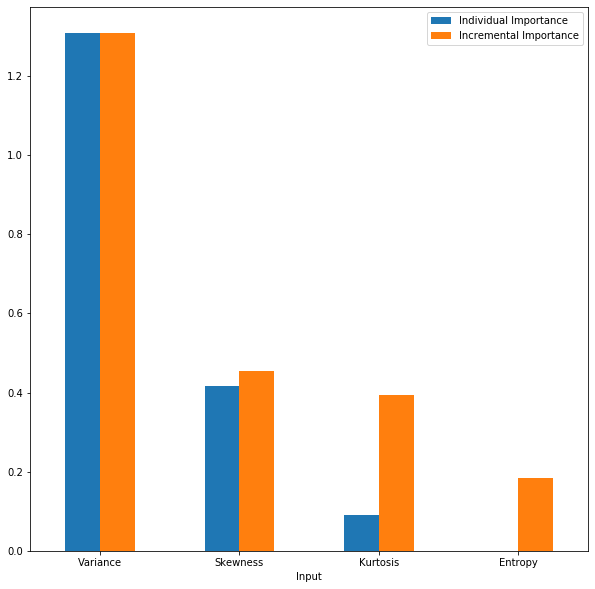

In [7]:
importance_df = pd.concat([importance_df_1.set_index(['input']),\
                           importance_df_2.set_index(['input'])], axis=1)
importance_df.reset_index(inplace=True)
importance_df = importance_df.rename(columns={'input': 'Input',\
    'individual_importance': 'Individual Importance', \
    'incremental_importance': 'Incremental Importance', \
    'selection_order': 'Selection Order'})
importance_df = importance_df[['Input', 'Individual Importance', \
    'Incremental Importance', 'Selection Order']]
importance_df = importance_df.sort_values(by=['Selection Order'],\
                                          ascending=True)
import pylab as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
importance_df[['Input', 'Individual Importance', 'Incremental Importance']]\
    .plot.bar(x='Input', rot=0, ax=ax)
plt.show()

Interestingly, both `Kurtosis` and `Entropy` provide little value when used in isolation, but when used in conjunction `Variance` and `Skewness` they have the potential to prove very useful.

#### Basic Model Training

Let's dive in and train a basic linear classifier on our dataset.

In [8]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
# Training
train_df = df.iloc[:1000]
x_train = train_df[['Variance', 'Skewness', 'Kurtosis']].values 
y_train = train_df['Is Fake'].values
classifier = LogisticRegression(random_state=0).fit(x_train, y_train)

# Testing
test_df = df.iloc[1000:]
x_test =  test_df[['Variance', 'Skewness', 'Kurtosis']].values
y_test = test_df['Is Fake'].values

# Out-of-sample predictions
predictions = classifier.predict(x_test)
test_df['Prediction'] = predictions

# Out-of-sample accuracy in %
'Out-Of-Sample Accuracy: %.2f%%' % (100. * classifier.score(x_test, y_test))

'Out-Of-Sample Accuracy: 98.92%'

#### Suboptimality of Trained Model

As we train models, we are faced with the following dilemma on resource allocation: are we better off investing time and money trying to improve our existing model with a more complex model, or have we already gotten the most out of existing inputs, and we should instead invest in acquiring complementary and/or more informative inputs?

Back to our bank note example, a 1% classification error corresponds to letting 10 millions through per billion of forged currencies. If a billion of forge currencies would take less than 10 millions of geniune currency to make, then the classification error is not yet low enough to render forgery unprofitable. So what should we do to drop this classification error further? Can we do better using the same inputs and a nonlinear model? Or should we seek additional complementary inputs?

This is where the method `df.kxy.classification_suboptimality` comes in.

In [9]:
'Classifier Suboptimality: %.4f nats' % test_df.kxy.classification_suboptimality(\
    'Prediction', 'Is Fake')

'Classifier Suboptimality: 0.0000 nats'

As it turns out, a simple logistic regression allows us to extract nearly all of the intrinsic value there is in using the 3 inputs above to determmine whether a bank note is a forgery. Thus, trying out a nonlinear model might not yield the highest ROI. 

That a nonlinear model would not perform materially better than a linear model is consistent with the visualization below, where it can be seen that a curved boundary would not necessarily do a much better job at separating geniune (green) from fake (red) notes than a straight line.

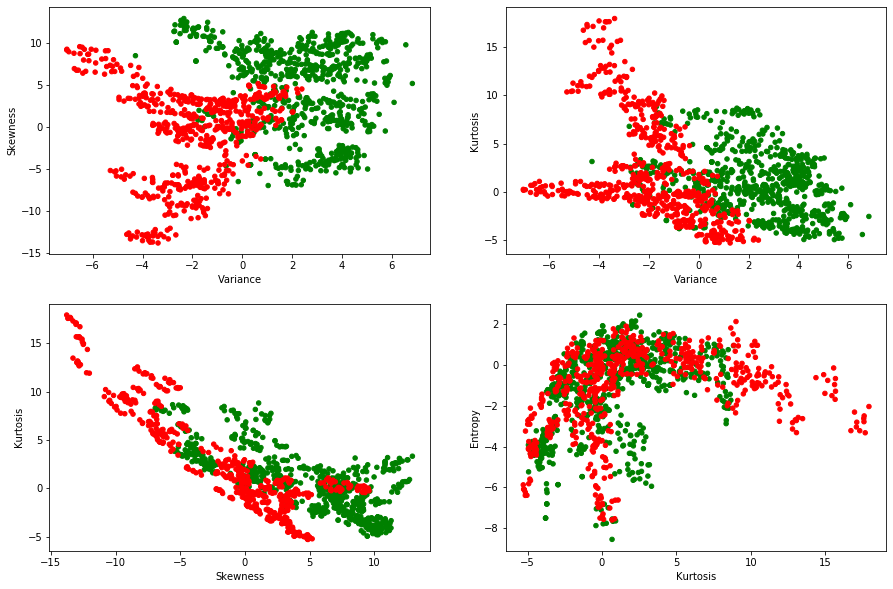

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
df.plot.scatter(ax=ax[0, 0], x='Variance', y='Skewness', c=df['Is Fake']\
    .apply(lambda x: 'r' if x == 1. else 'g'))
df.plot.scatter(ax=ax[0, 1], x='Variance', y='Kurtosis', c=df['Is Fake']\
    .apply(lambda x: 'r' if x == 1. else 'g'))
df.plot.scatter(ax=ax[1, 0], x='Skewness', y='Kurtosis', c=df['Is Fake']\
    .apply(lambda x: 'r' if x == 1. else 'g'))
df.plot.scatter(ax=ax[1, 1], x='Kurtosis', y='Entropy',  c=df['Is Fake']\
    .apply(lambda x: 'r' if x == 1. else 'g'))
plt.show()

### Regression

Much of the analysis above can be extended to regression problems. We consider one such problem from the UCI machine learning repository below.

In [11]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'\
                 '00243/yacht_hydrodynamics.data', sep='[ ]{1,2}',\
                 names=['Longitudinal Position', 'Prismatic Coeefficient',\
                        'Length-Displacement', 'Beam-Draught Ratio',\
                        'Length-Beam Ratio', 'Froude Number',\
                        'Residuary Resistance'])
df.rename(columns={col: col.title() for col in df.columns})

,Longitudinal Position,Prismatic Coeefficient,Length-Displacement,Beam-Draught Ratio,Length-Beam Ratio,Froude Number,Residuary Resistance
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18
...,...,...,...,...,...,...,...
303,-2.3,0.600,4.34,4.23,2.73,0.350,8.47
304,-2.3,0.600,4.34,4.23,2.73,0.375,12.27
305,-2.3,0.600,4.34,4.23,2.73,0.400,19.59
306,-2.3,0.600,4.34,4.23,2.73,0.425,30.48


#### Problem Feasibility

In [12]:
label_column = 'Residuary Resistance'
# Pre-Learning: How feasible or solvable is this problem? Are inputs any useful?
'Feasibility: %.4f nats, Entropy: %.4f nats' % (\
    df.kxy.regression_feasibility(label_column), \
    kxy.scalar_continuous_entropy(df[label_column].values))

'Feasibility: 3.3846 nats, Entropy: 3.6338 nats'

#### Input Importance

In [13]:
# Pre-Learning: How useful is each input individually?
importance_df_1 = df.kxy.individual_input_importance(label_column).rename(columns={\
        'input': 'Input', 'individual_importance': 'Individual Importance',\
        'normalized_individual_importance': 'Normalized Individual Importance',\
        'cum_normalized_individual_importance': 'Cum Normalized Individual Importance'})\
        .round(2).set_index(['Input'])
importance_df_1

,Individual Importance,Normalized Individual Importance,Cum Normalized Individual Importance
Input,,,
Froude Number,2.21,1.0,1.0
Length-Displacement,0.00,0.0,1.0
Longitudinal Position,0.00,0.0,1.0
Prismatic Coeefficient,0.00,0.0,1.0
Beam-Draught Ratio,0.00,0.0,1.0
Length-Beam Ratio,0.00,0.0,1.0


In [14]:
# Pre-Learning: How much value does each input add marginally?
importance_df_2 = df.kxy.incremental_input_importance(label_column).rename(columns={\
        'input': 'Input', 'incremental_importance': 'Incremental Importance',\
        'normalized_incremental_importance': 'Normalized Incremental Importance',\
        'selection_order': 'Selection Order', 'cum_normalized_incremental_importance': \
                'Cum Normalized Incremental Importance'}).round(2).set_index(['Input'])
importance_df_2

,Selection Order,Incremental Importance,Normalized Incremental Importance,Cum Normalized Incremental Importance
Input,,,,
Froude Number,1,2.21,0.78,0.78
Beam-Draught Ratio,2,0.13,0.05,0.83
Length-Displacement,3,0.12,0.04,0.88
Longitudinal Position,4,0.12,0.04,0.92
Prismatic Coeefficient,5,0.12,0.04,0.96
Length-Beam Ratio,6,0.11,0.04,1.00


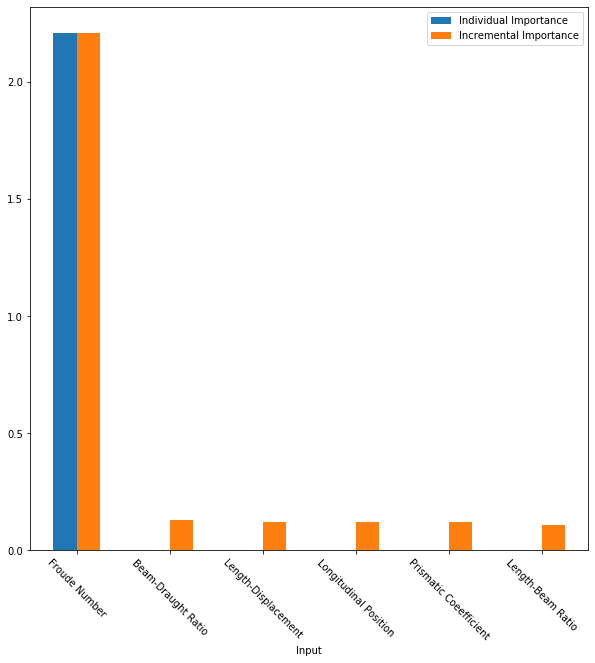

In [15]:
# Putting everything together in a plot
importance_df = pd.concat([importance_df_1, importance_df_2], axis=1)
importance_df.reset_index(inplace=True)
importance_df.rename(columns={'index': 'Input'}, inplace=True)
importance_df = importance_df[['Input', 'Individual Importance', \
    'Incremental Importance', 'Selection Order']]
importance_df = importance_df.sort_values(by=['Selection Order'],\
                                          ascending=True)
import pylab as plt
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
importance_df[['Input', 'Individual Importance', 'Incremental Importance']]\
    .plot.bar(x='Input', rot=-45, ax=ax)
plt.show()

#### Basic Model Training

In [16]:
# Learning (Basic Linear Regression)
from sklearn.linear_model import LinearRegression
# Training
train_size = 200
train_df = df.iloc[:train_size]
x_train = train_df[['Longitudinal Position', 'Prismatic Coeefficient',\
                        'Length-Displacement', 'Beam-Draught Ratio',\
                        'Length-Beam Ratio', 'Froude Number']].values
y_train = train_df[label_column].values
model = LinearRegression().fit(x_train, y_train)

# Testing
test_df = df.iloc[train_size:]
x_test = test_df[['Longitudinal Position', 'Prismatic Coeefficient',\
                        'Length-Displacement', 'Beam-Draught Ratio',\
                        'Length-Beam Ratio', 'Froude Number']].values
y_test = test_df[label_column].values

# Out-of-sample predictions
predictions = model.predict(x_test)
test_df['Prediction'] = predictions

# Out-of-sample accuracy (R^2)
'Linear Regression Out-Of-Sample R^2: %.3f' % (model.score(x_test, y_test))

'Linear Regression Out-Of-Sample R^2: 0.648'

#### Absolute Suboptimality of Trained Model

As in the case of classification models, we may quantify the extent to which the trained regression model can be improved without resorting to additional inputs, and without imposing any restriction on the model that could bring about said improvement.

In [17]:
'Linear Regression Suboptimality: %.4f nats' % \
    test_df.kxy.regression_suboptimality('Prediction', label_column)

'Linear Regression Suboptimality: 1.7212 nats'

The suboptimality score represents about a third of the feasibility score, which strongly suggests that accuracy could be improved without resorting to additional inputs. Equivalently, this provides evidence of nonlinearity in the relationship between inputs and label. 

Let's try and unleash some of this untapped potential using Gaussian process regression (GPR). Given that the `Froude Number` input is the only input with a non-negligible individual input importance score, we consider a simple univariate GPR model using the RBF kernel.


In [18]:
import GPy # pip install GPy
x_train = train_df[['Froude Number']].values
x_test = test_df[['Froude Number']].values
kernel = GPy.kern.RBF(input_dim=1)
gp_model = GPy.models.GPRegression(x_train, y_train[:, None], kernel)
gp_model.optimize()
gp_predictions = gp_model.predict(x_test)[0].flatten()

# Out-of-sample accuracy (R^2)
ss_res = ((gp_predictions-y_test)**2).sum()
ss_tot = ((y_test-y_test.mean())**2).sum()
'Univariate RBF-GPR Out-Of-Sample R^2: %.3f' % (1.-(ss_res/ss_tot))

'Univariate RBF-GPR Out-Of-Sample R^2: 0.979'

As expected, a simple RBF-GPR model using the `Froude Number` single input exploits the nonlineariy previously evidenced by the suboptimality analysis of the `kxy` package, thereby drastically increasing the out-of-sample $R^2$ from 0.65 to 0.98. 

Let's visualize the data and trained models.

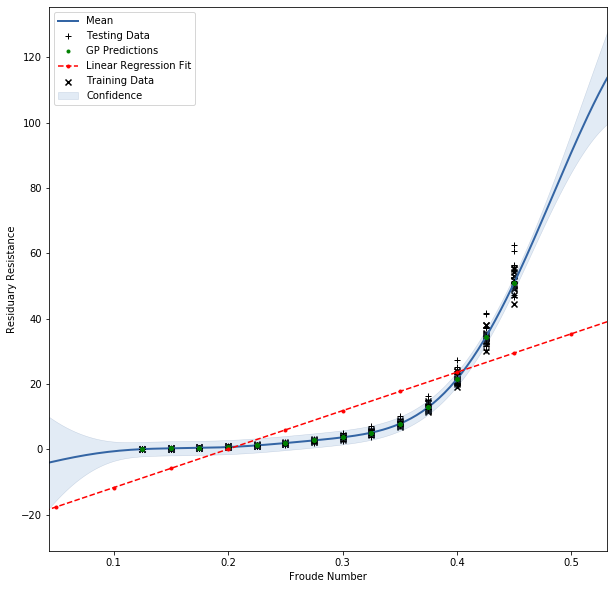

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gp_model.plot_data(ax=ax, label='Training Data')
gp_model.plot(ax=ax, plot_data=False)
ax.plot(x_test, y_test, '+', c='k', label='Testing Data')
ax.plot(x_test, gp_predictions, '.', c='green', label='GP Predictions')
model = LinearRegression().fit(x_train, y_train)
import numpy as np
lr_x = np.arange(0., 0.7, 0.05)
lr_y = model.predict(lr_x[:, None])
ax.plot(lr_x, lr_y, '.--', c='red', label='Linear Regression Fit')
ax.set_xlabel('Froude Number')
ax.set_ylabel(label_column)
plt.legend()
plt.show()

The fit is great, but as evidenced by the fact that the same value of the `Frounde Number` input can result in a wide range of outputs for large froude numbers, there is still some ambiguity that might be alleviated with additional inputs. 

Let's see how optimal the `kxy` package thinks our GPR model is, first as a model for predicting the output solely using the `Froude Number` input, then as a model for predicting the output using all six original inputs.

In [20]:
test_df['GP Predictions'] = gp_predictions
'RBG-GPR Suboptimality (1D GPR for 1 Input): %.4f nats' % \
    test_df.kxy.regression_suboptimality('GP Predictions', label_column,\
    input_columns=['Froude Number'])

'RBG-GPR Suboptimality (1D GPR for 1 Input): 0.0001 nats'

In [21]:
test_df['GP Predictions'] = gp_predictions
'RBG-GPR Suboptimality (1D GPR for all 6 inputs): %.4f nats' % \
    test_df.kxy.regression_suboptimality('GP Predictions', label_column,\
    input_columns=['Longitudinal Position', 'Prismatic Coeefficient',\
    'Length-Displacement', 'Beam-Draught Ratio',\
    'Length-Beam Ratio', 'Froude Number'])

'RBG-GPR Suboptimality (1D GPR for all 6 inputs): 1.3198 nats'

The `kxy` package suggests that the GPR model can hardly be improved upon without resorting to one of the other five inputs and that, despite the drastic increase in $R^2$ from the linear regression model, there exists a multivariate nonlinear regression model that can materially outperform our univariate GP regression model. 

Let's consider a multivariate RBF-GPR model with ARD (automatic relevance determination).

In [22]:
x_train = train_df[['Longitudinal Position', 'Prismatic Coeefficient',\
    'Length-Displacement', 'Beam-Draught Ratio',\
    'Length-Beam Ratio', 'Froude Number']].values
x_test = test_df[['Longitudinal Position', 'Prismatic Coeefficient',\
    'Length-Displacement', 'Beam-Draught Ratio',\
    'Length-Beam Ratio', 'Froude Number']].values
kernel = GPy.kern.RBF(input_dim=x_train.shape[1], ARD=True)
gp_model_mult = GPy.models.GPRegression(x_train, y_train[:, None], kernel)
gp_model_mult.optimize()
multi_gp_predictions = gp_model_mult.predict(x_test)[0].flatten()

# Out-of-sample accuracy (R^2)
ss_res = ((multi_gp_predictions-y_test)**2).sum()
ss_tot = ((y_test-y_test.mean())**2).sum()
'Multivariate RBF-GPR Out-Of-Sample R^2: %.3f' % (1.-(ss_res/ss_tot))

'Multivariate RBF-GPR Out-Of-Sample R^2: 0.955'

In [23]:
test_df['Multivariate GP Prediction'] = multi_gp_predictions
'Multivariate RBF-GPR Suboptimality: %.4f nats' % \
    test_df.kxy.regression_suboptimality('Multivariate GP Prediction',\
    label_column, input_columns=['Longitudinal Position', \
    'Prismatic Coeefficient', 'Length-Displacement', 'Beam-Draught Ratio',\
    'Length-Beam Ratio', 'Froude Number'])

'Multivariate RBF-GPR Suboptimality: 1.7327 nats'

It turns out that a multivariate RBF-GPR model with ARD doesn't necessarily perform better. Without getting too technical, this is theoretically not supposed to be the case as univariate RBF GPs with ARD are special and degenerate cases of multivariate RBF-GPs; they correspond to using an infinite input lengthscale or a 0 inverse input lengthscale. `GPy` however uses as model parameter input lengthscales, not their inverses, and as such `GPy` cannot completely nullify the effect of useless inputs. Incremental input importance is therefore of importance, even when `ARD=True`.

More importantly, sometimes we may want to work incrementally, training a regression model, shipping it to production, then continuously refining it, focusing on *reducing the magnitude of its errors*, instead of starting from scratch. This is where the notion of **additive suboptimality** comes in.

#### Additive Suboptimality of Trained Model

The additive suboptimality analysis for regression models quantifies the extent to which a trained regression model can be improved without resorting to additional inputs, but in an additive fashion. Specifically, if our trained regression model reads $y = f(x) + \epsilon$, the additive suboptimality analysis quantifies the extent to which its residuals, namely $y-f(x)$, can be predicted using the same inputs $x$. 

Additive suboptimality is typically smaller than (absolute) suboptimality as it places restrictions on how the trained model could be improved.

Let's calculate the additive suboptimality score of our trained univariate RBF-GP model using the `kxy` package.

In [24]:
'Additive Suboptimality: %.4f nats' % \
    test_df.kxy.regression_additive_suboptimality(\
    'GP Predictions', label_column, input_columns=[\
        'Longitudinal Position', 'Prismatic Coeefficient',\
        'Length-Displacement', 'Beam-Draught Ratio',\
        'Length-Beam Ratio', 'Froude Number'])

'Additive Suboptimality: 0.1762 nats'

Let's analyze input importance to predict our residuals.

In [25]:
# Calculating residuals
residual_column = 'GP Residuals'
train_df[residual_column] = y_train - gp_model.predict(\
    train_df[['Froude Number']].values)[0].flatten()
test_df[residual_column] = y_test - gp_model.predict(\
    test_df[['Froude Number']].values)[0].flatten()

# Calculating training incremental input importance
# to predict residuals.
train_df.kxy.incremental_input_importance(residual_column, \
    input_columns=['Longitudinal Position', 'Prismatic Coeefficient',\
        'Length-Displacement', 'Beam-Draught Ratio',\
        'Length-Beam Ratio', 'Froude Number']).rename(columns={\
        'input': 'Input', 'incremental_importance': 'Incremental Importance',\
        'normalized_incremental_importance': 'Normalized Incremental Importance',\
        'cum_normalized_incremental_importance': \
        'Cum Normalized Incremental Importance', 'selection_order':\
        'Selection Order'}).round(3).set_index(['Input'])


,Selection Order,Incremental Importance,Normalized Incremental Importance,Cum Normalized Incremental Importance
Input,,,,
Longitudinal Position,1,0.030,0.472,0.472
Length-Displacement,2,0.010,0.154,0.626
Beam-Draught Ratio,3,0.015,0.237,0.862
Prismatic Coeefficient,4,0.005,0.080,0.942
Froude Number,5,0.002,0.029,0.972
Length-Beam Ratio,6,0.002,0.028,1.000


As expected, the input importance scores are not overwhelming. Let's start with a simple linear regression model to predict the residuals of the univariate GP regression model.

In [26]:
x_train = train_df[['Longitudinal Position', \
                    'Prismatic Coeefficient', 'Length-Displacement', \
                    'Beam-Draught Ratio', 'Length-Beam Ratio', \
                    'Froude Number']].values
y_train = train_df[residual_column].values
model = LinearRegression().fit(x_train, y_train)

# Testing
x_test = test_df[['Longitudinal Position', \
                  'Prismatic Coeefficient', 'Length-Displacement', \
                  'Beam-Draught Ratio', 'Length-Beam Ratio', \
                  'Froude Number']].values
y_test = test_df[residual_column].values

# Out-of-sample predictions
res_predictions = model.predict(x_test)
test_df['Residual Prediction'] = predictions

# Out-of-sample accuracy (R^2)
'Residuals Linear Regression Out-Of-Sample R^2: %.3f' % \
    (model.score(x_test, y_test))

'Residuals Linear Regression Out-Of-Sample R^2: 0.067'

In [27]:
test_df['GP+LR Predictions'] = test_df['GP Predictions'] + res_predictions
# Out-of-sample accuracy (R^2)
ss_res = ((test_df['GP+LR Predictions'].values-test_df[label_column])**2).sum()
ss_tot = ((test_df[label_column]-test_df[label_column].mean())**2).sum()
'Univariate RBF-GPR + Linear Regression Out-Of-Sample R^2: %.3f' % \
    (1.-(ss_res/ss_tot))

'Univariate RBF-GPR + Linear Regression Out-Of-Sample R^2: 0.981'

We were able to slightly improve our univariate GPR model, but more can be done, and the `kxy` can help every step of the way.

### Asset Management

Much of the theory and practice of quantitative asset management is routed in implicitly or explicitly assuming that asset returns are i.i.d. Gaussian, despite well documented empirical evidence to the contrary. From the widespread use of linear regression and regularized versions thereof (e.g. LASSO, Ridge and Elastic-Net) in signal construction, to the use of Pearson's correlation to measure risk, to the use of CAPM's beta and alpha coefficients to measure market exposure and idiosyncratic expected return respectively, examples abound.

However, relaxing the i.i.d. Gaussian assumption could be a daunting undertaking to some quants, and academic models that do so might not necessarily be robust enough for production use. This is where the `kxy` package comes in.

We provide methods that exploit empirical evidence of nonlinearity and memory in the quantification of associations between random variables, and then infer the property of interest in the *i.i.d. Gaussian* paradigm that is consistent with the full amount of associations observed empirically, not just linear memoryless associations as would be the case if the property was estimated directly. We call these properties ***information-adjusted***. 

Find out more in the Theoretical Foundation section.

#### Information-Adjusted Correlation

We illustrate how to estimate an *information-adjusted correlation matrix* using the `kxy` package and the unofficial Yahoo Finance API. We query daily prices for stocks in the S&P 100, as well as the S&P 500 index, and calculate their information-adjusted autocorrelation matrix.

In [28]:
from yahooquery import Ticker
tickers = Ticker('aapl abbv abt acn adbe aig all amgn amt amzn axp '\
                 'ba bac biib bk bkng blk bmy brk-b c cat chtr cl '\
                 'cmcsa cof cop cost crm csco cvs cvx dd dhr dis '\
                 'dow duk emr exc f fb fdx gd ge gild gm goog googl '\
                 'gs hd hon ibm intc jnj jpm khc kmi ko lly lmt low '\
                 'ma mcd mdlz mdt met mmm mo mrk ms msft nee nflx '\
                 'nke nvda orcl oxy pep pfe pg pm pypl qcom rtx sbux '\
                 'slb so spg t tgt tmo txn unh unp ups usb v vz wba '\
                 'wfc wmt xom ^gspc')

In [29]:
prices_df = tickers.history(period='5y')

In [30]:
all_closes = prices_df['adjclose'].reset_index()
flat_closes = pd.concat([all_closes[all_closes['symbol'] == asset].rename(\
    columns={'adjclose': asset}).set_index(['date'])[[asset]]\
    for asset in list(set(all_closes['symbol'].values))], axis=1).dropna()
daily_returns = flat_closes.pct_change().dropna()

##### Nonlinearity

Although nonlinearities and outliers might appear to be synonymous, we consider outliers to be observations that are small in number, extreme in magnitude, and best explained as belonging to a different distribution than the rest of the data. E.g. Recording errors and asset returns in crisis situations. Data that constitute evidence of nonlinearities on the other hand tend to be larger in number, also extreme in magnitude, but are best explained as belonging to the tails of the same distribution as the rest of the data.

Both nonlinearities and outliers affect the standard sample estimator of Pearson's correlation, but in opposing ways.

As it is not robust to outliers, outliers will cause the standard sample estimator of Pearson's correlation to overshoot.

Additionally, Pearson's correlation only captures linear associations in data. When variables exhibit nonlinear associations or, equivalently, when the true data generating distribution is not Gaussian, Pearson's correlation might underestimate the amount of association between variables.

The `kxy` package provides two methods for estimating a correlation matrix while addressing the two limitations above. 

The `robust-pearson` method estimates a Pearson correlation matrix assuming variables are Gaussian, in a way that is robust to outliers. This is done by calculating the Spearman rank correlation matrix, and mapping each entry to the equivalent Pearson's correlation, assuming the corresponding pair of variables are jointly Gaussian. The robustness of this approach comes from the use of ranks instead of observed values in the calculation of a Spearman rank correlation. 

It is important to stress that the validity of this method, as an estimator of Pearson's correlation matrix *relies on the assumption that variables are Gaussian*. In particular, if $x$ and $y$ are two scalar random variables, and $f$ and $g$ are two increasing functions, this method will return the same result for all the pairs $(f(x), g(y))$ for *any* increasing functions $f$ and $g$, but it will only be a valid estimator of Pearson's correlation if $(f(x), g(y))$ are jointly Gaussian. 

Often times inputs are known not to be Gaussian, and a more realistic assumption is that there exists a feature mapping $(x_1, \dots, x_d) \to (f_1(x_1), \dots, f_d(x_d))$ that maps the non-Gaussian inputs into features that are jointly Gaussian. When the transformations $f_i$ are assumed to be increasing but are not explicitly needed, this method always provides a valid estimator for the Pearson correlation matrix of the features, without having to learn the feature map making inputs Gaussian.

In [31]:
rps_corr = daily_returns.kxy.corr(method='robust-pearson')

The `information-adjusted` method estimates the Pearson correlation matrix that should be used to account for both linear and nonlinear associations in the data, and is robust to outliers. Specifically, for each pair of variables, we estimate their mutual information $i$ in a way that is both robust and captures nonlinear associations, and we infer the **information-adjusted** correlation as $\rho = \text{sgn}(c)\sqrt{1-e^{-2i}}$, where $c$ is the Pearson correlation. When empirical evidence suggest an absence of nonlinear association, the information-adjusted correlation is equal to Pearson's correlation. In general however, unlike Pearson's correlation, *the information-adjusted correlation is 0 if and only the two variables are statistically independent*. 

The current version of the `kxy` package estimates the mutual information $i$ by applying the [principle of maximum entropy](https://en.wikipedia.org/wiki/Principle_of_maximum_entropy) to each pair of variables, using as constraint their Spearman rank correlation.

While the `robust-pearson` method implicitly uses the workflow *Spearman Rank Correlation* $\rightarrow$ **Gaussian Copula** $\rightarrow$ *Mutual Information* $\rightarrow$ *Gaussian Mapping*, the `information-adjusted` method uses the workflow *Maximum-Entropy Constraints (e.g. Spearman Rank Correlation)* $\rightarrow$ **Maximum-Entropy Copula** $\rightarrow$ *Mutual Information* $\rightarrow$ *Gaussian Mapping*. 

When the Spearman rank correlation is used as maximum-entropy constraint in the second workflow (as in the current version of the package), the estimated mutual-information will be smaller than the mutual information assumming the Gaussian copula (because the Gaussian copula is not the maximum-entropy copula under Spearman rank correlation constraints) and the `information-adjusted` correlation will be smaller in absolute value than the `robust-person` correlation. 

As more constraints are addeed to the maximum-entropy problem, the mutual information in the second workflow converges to the mutual information of the true (unknown) data generating distribution, and the information-adjusted correlation converges to the true Pearson correlation of any Gaussian features $(f_1(x_1), \dots, f_d(x_d))$ obtained through invertible maps.

In [32]:
ia_corr = daily_returns.kxy.corr(method='information-adjusted')
ps_corr = daily_returns.kxy.corr(method='pearson')

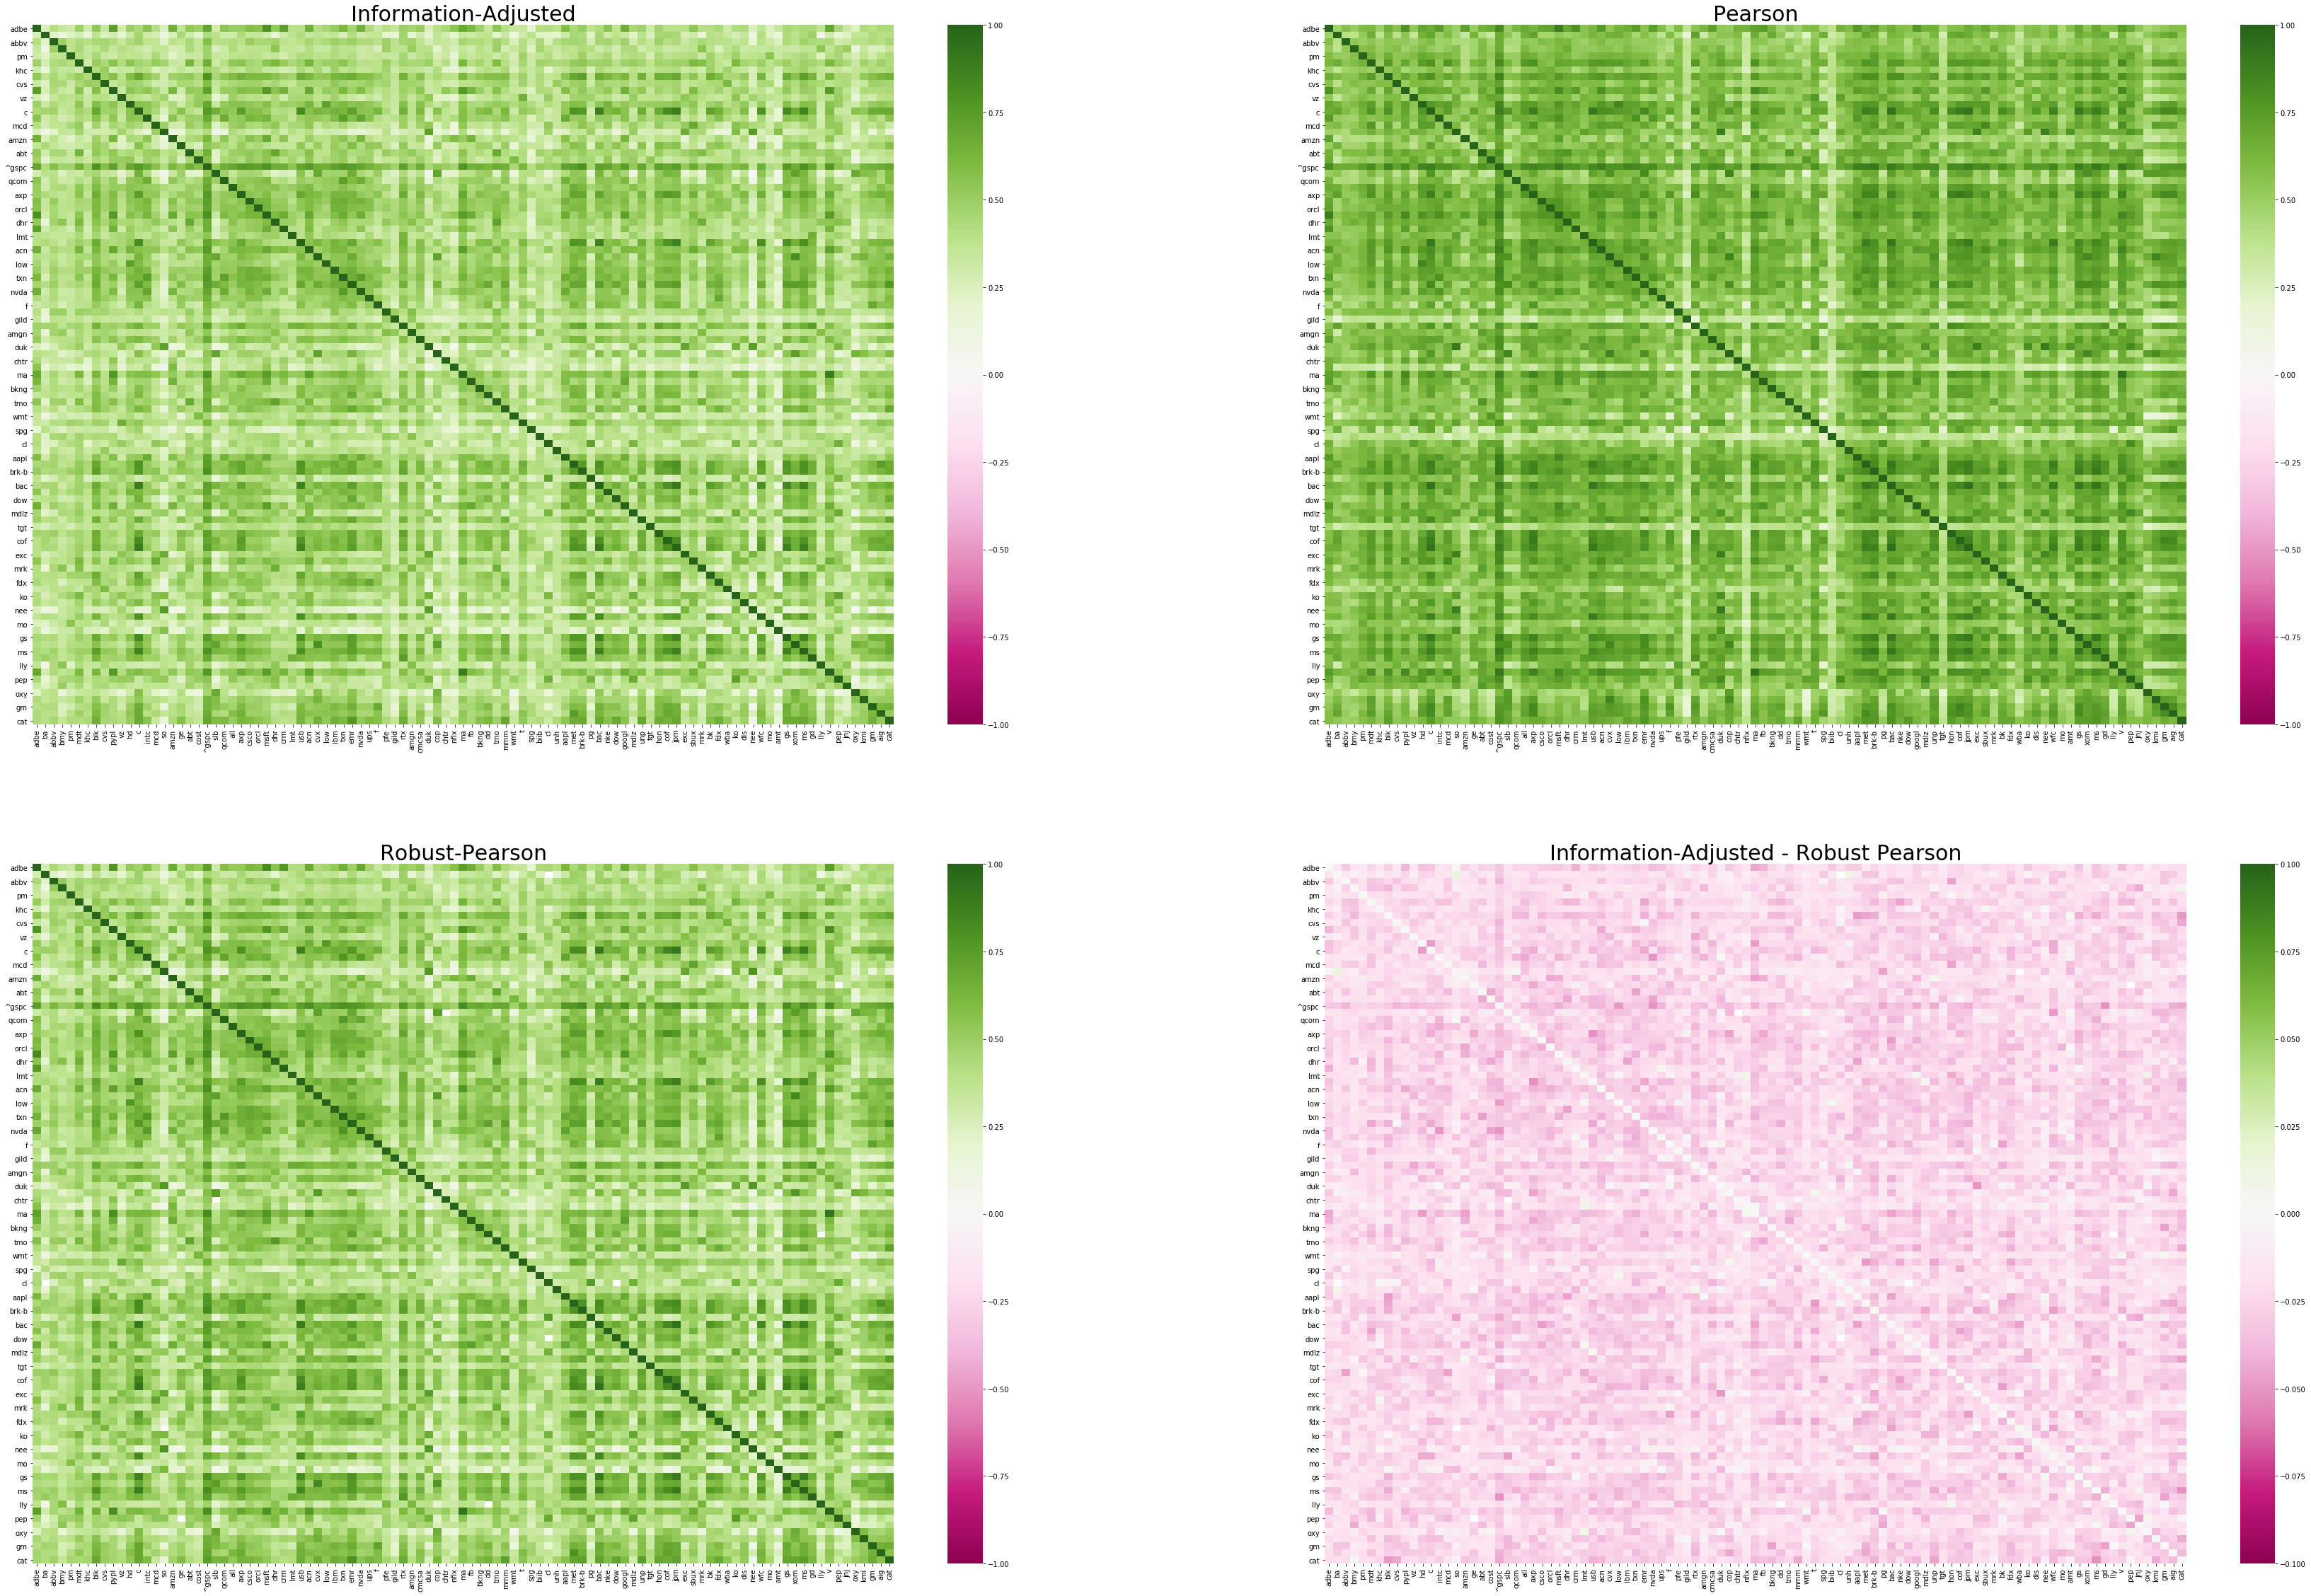

In [33]:
import seaborn as sns
fig, ax = plt.subplots(2, 2, figsize=(60, 40))
sns.heatmap(ia_corr, vmin=-1, vmax=1, center=0, cmap='PiYG', ax=ax[0, 0])
ax[0, 0].set_title('Information-Adjusted', fontsize=30)
sns.heatmap(rps_corr, vmin=-1, vmax=1, center=0, cmap='PiYG', ax=ax[1, 0])
ax[1, 0].set_title('Robust-Pearson', fontsize=30)
sns.heatmap(ps_corr, vmin=-1, vmax=1, center=0, cmap='PiYG', ax=ax[0, 1])
ax[0, 1].set_title('Pearson', fontsize=30)
sns.heatmap(ia_corr-rps_corr, vmin=-.1, vmax=.1, center=0, cmap='PiYG', ax=ax[1, 1])
ax[1, 1].set_title('Information-Adjusted - Robust Pearson', fontsize=30)
plt.show()

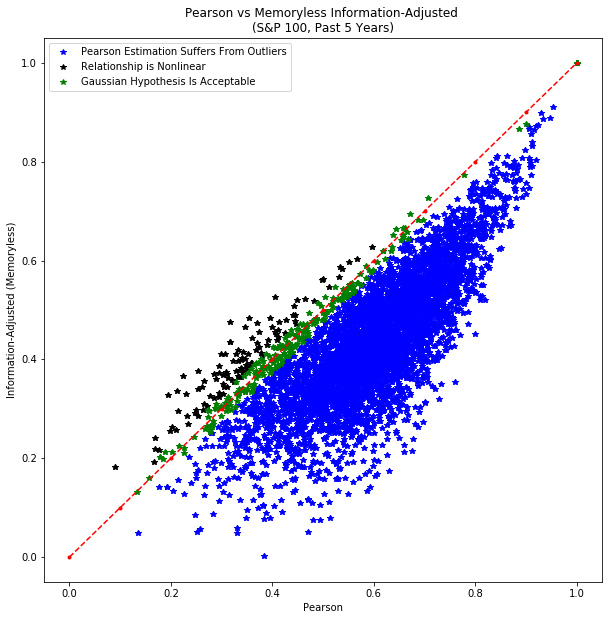

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(ps_corr.values[np.abs(ps_corr.values) > np.abs(ia_corr.values)+0.025].flatten(),\
        ia_corr.values[np.abs(ps_corr.values) > np.abs(ia_corr.values)+0.025].flatten(),\
        '*', c='blue', label='Pearson Estimation Suffers From Outliers')
ax.plot(ps_corr.values[np.abs(ps_corr.values) < np.abs(ia_corr.values)-0.025].flatten(),\
        ia_corr.values[np.abs(ps_corr.values) < np.abs(ia_corr.values)-0.025].flatten(),\
        '*', c='black', label='Relationship is Nonlinear')
selector = np.logical_and((np.abs(ps_corr.values) <= np.abs(ia_corr.values)+0.025), \
    (np.abs(ps_corr.values) >= np.abs(ia_corr.values)-0.025))           
ax.plot(ps_corr.values[selector].flatten(),\
        ia_corr.values[selector].flatten(),\
        '*', c='green', label='Gaussian Hypothesis Is Acceptable')
ax.plot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1), '.--', c='red')
ax.set_xlabel('Pearson')
ax.set_ylabel('Information-Adjusted (Memoryless)')
ax.set_title('Pearson vs Memoryless Information-Adjusted \n(S&P 100, Past 5 Years)')
plt.legend()
plt.show()

Clearly, if returns were i.i.d. Gaussian, the `pearson` method wouldn't produce a correlation matrix so different from both `robust-pearson` and `information-adjusted` matrices. Additionally, a `pearson` correlation coefficient exceeding an `information-adjusted` correlation coefficient by more than a few percentage points is too big to be attributed to either the use of Spearman rank correlation as constraint in the `information-adjusted` method or the difference between the Gaussian copula and the maximum-entropy copula. It is clear evidence that the standard estimator of Pearson's correlation overshot due to outliers. The blue stars above are a perfect example (COVID-19?).

##### Memory

Another important assumption which we have overlooked in the analysis above is that observations are independent (the first i in *i.i.d. Gaussian*). In the case of asset returns, this is equivalent to saying that there is no memory in financial markets, assumption that goes against the longevity of the quantitative asset management business. 


The approaches discussed above are easily extended to factor-in the presence of memory in the time series. 


In the case of the `robust-pearson` method, it is assumed that the increasing feature mapping turns the samples into that of a Gaussian Auto-Regressive process (Gaussian AR(p)), where is the natural extension of Gaussian random vectors to time series. Like Gaussian random vectors, which are maximum-entropy under Pearson covariance constraints, Gaussian VAR(p) processes are maximum-entropy processes under the first `p` autocovariance lags constraints. 

The workflow becomes *Spearman Rank Auto-Correlation Function* $\rightarrow$ **Gaussian Time Series Copula** $\rightarrow$ *Mutual Information Rate* $\rightarrow$ *Gaussian Mapping*. The Gaussian Mapping is generalized to time series and reads: $\rho = \text{sgn}(c)\sqrt{1-e^{-2\bar{i}}}$ with $\bar{i}$ the *mutual information rate*, which is available in closed form for Gaussian AR(p) processes. Note that when the time series is memoryless, we recover the memoryless robust-pearson correlation discussed above.


In the case of the `information-adjusted` method, the workflow becomes *Spearman Rank Auto-Correlation Function* $\rightarrow$ **Maxium-Entropy Time Series Copula** $\rightarrow$ *Mutual Information Rate* $\rightarrow$ *Gaussian Mapping*. We will not discuss this option further as maximum-entropy in the dual space is not *yet* supported for time series.

To capture the effect of memory on `robust-pearson` estimation, one should set the parameter `p` of the `corr` method to a non-zero value. When an integer is provided, it corresponds to the number of lags of autocovariance constraints to use in the maximum-entropy problem. When `p` is set to `None`, the number of lags is automatically inferred. The default value for `p` is 0, which corresponds to assuming that the time series are memoryless.

In [39]:
rps_corr_m = daily_returns.kxy.corr(method='robust-pearson', p=None)

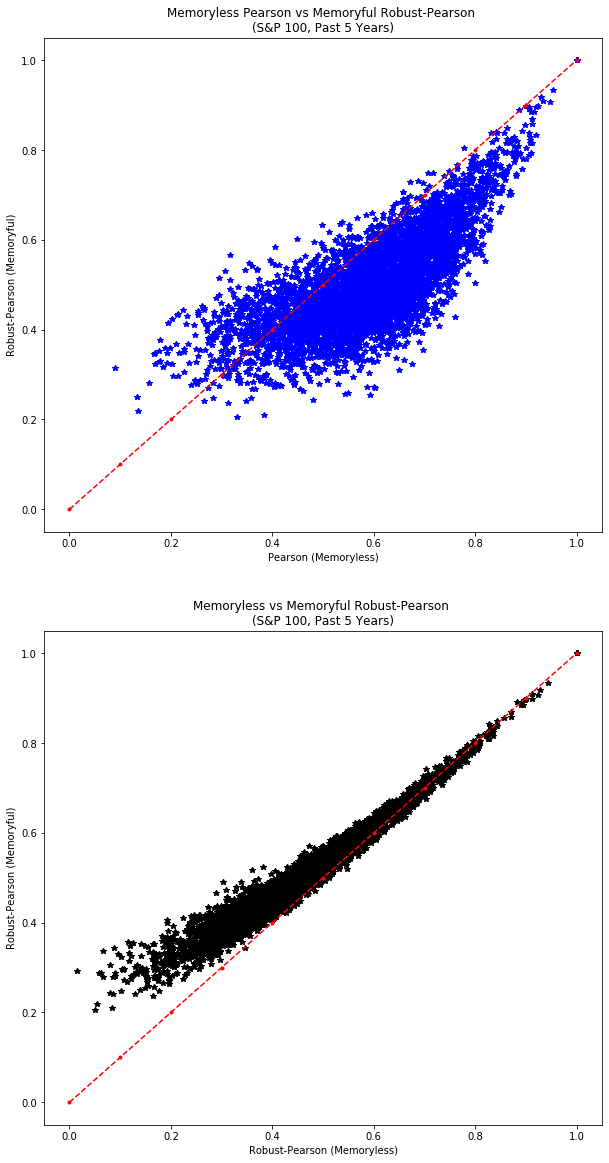

In [53]:
fig, ax = plt.subplots(2, 1, figsize=(10, 20))
ax[0].plot(ps_corr.values.flatten(), rps_corr_m.values.flatten(), '*', c='blue')
ax[0].plot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1), '.--', c='red')
ax[0].set_xlabel('Pearson (Memoryless)')
ax[0].set_ylabel('Robust-Pearson (Memoryful)')
ax[0].set_title('Memoryless Pearson vs Memoryful Robust-Pearson \n(S&P 100, Past 5 Years)')

ax[1].plot(rps_corr.values.flatten(), rps_corr_m.values.flatten(), '*', c='black')
ax[1].plot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1), '.--', c='red')
ax[1].set_xlabel('Robust-Pearson (Memoryless)')
ax[1].set_ylabel('Robust-Pearson (Memoryful)')
ax[1].set_title('Memoryless vs Memoryful Robust-Pearson \n(S&P 100, Past 5 Years)')
plt.show()

The fact that the blue cloud in the first figure above got lifted up, and the black cloud deviates from the red diagonal line is empirical evidence of meory in financial markets.

#### Information-Adjusted Beta

The CAPM beta, defined as $\beta := \mathbb{C}\text{orr}\left(r, r_m\right) \sqrt{\frac{\mathbb{V}\text{ar}(r)}{\mathbb{V}\text{ar}(r_m)}}$, measures the first-order (linear) exposure of a portfolio or an asset returns $r$ to the market return $r_m$. The underlying assumption is that $r$ and $r_m$ are jointly Gaussian and linearly related, and $\beta$ is often interpreted as the number of dollars of the market index one should sell to completely offset the market risk per dollar of asset/portfolio holdings. Moreover, Pearson's correlation $\mathbb{C}\text{orr}\left(r, r_m\right)$ is typically estimated using the standard sample estimator.

However, if asset/portfolio and market returns either suffer from outliers, or are not jointly normal, or are not memoryless, the standard estimator for beta will result in poorly hedged portfolios.

To address these limitations, we provide beta estimation methods in the `kxy` package that mirror previously discussed correlation estimation methods, namely `pearson`, `robust-pearson`, and `information-adjusted`, the second with memoryless and memoryful flavors.

In [68]:
# Beta of S&P 100 stocks relative to the S&P 500 index
betas = pd.concat([daily_returns.kxy.beta('^gspc', method='information-adjusted')\
                   .rename(columns={'beta': 'Information-Adjusted (Memoryless)'}),\
                   daily_returns.kxy.beta('^gspc', method='robust-pearson', p=0)\
                   .rename(columns={'beta': 'Robust-Pearson (Memoryless)'}),\
                   daily_returns.kxy.beta('^gspc', method='robust-pearson', p=None)\
                   .rename(columns={'beta': 'Robust-Pearson (Memoryful)'}),\
                   daily_returns.kxy.beta('^gspc', method='pearson')\
                   .rename(columns={'beta': 'Standard'})], axis=1)

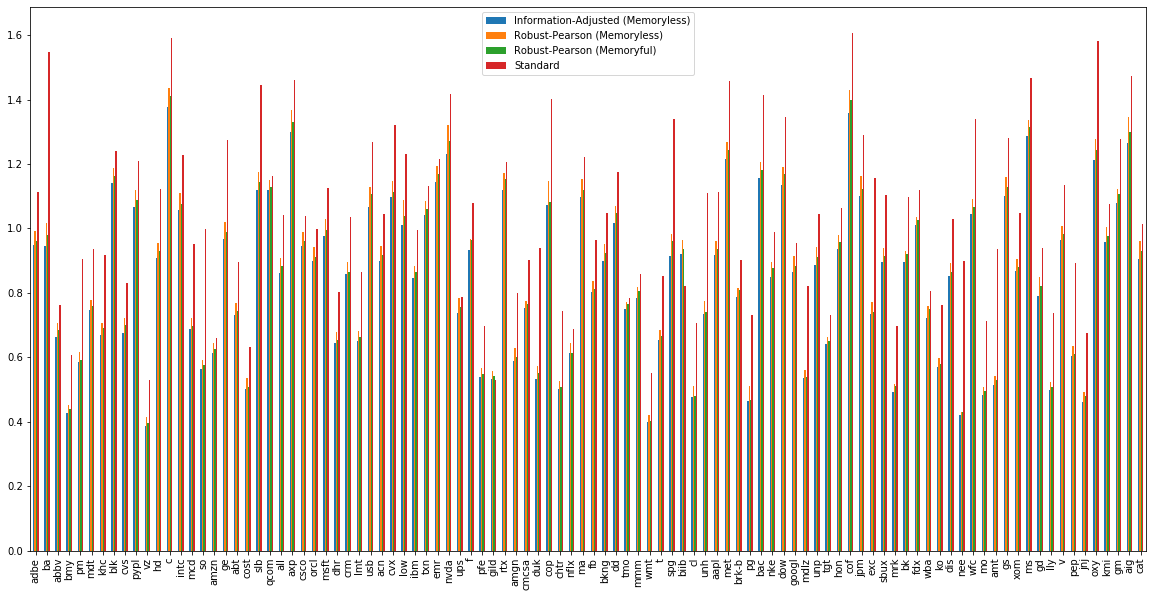

In [69]:
fig, ax = plt.subplots(figsize=(20, 10))
betas.plot.bar(ax=ax)
plt.show()